In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2023-08-01 15:25:31 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [ ]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  LD_PRELOAD = /usr/lib/x86_64-linux-gnu/libtcmalloc.so.4
  JULIA_NUM_THREADS = 2



<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />

In [ ]:
using Pkg

In [ ]:
Pkg.add(url="https://github.com/JuliaQuantumControl/GRAPELinesearchAnalysis.jl.git")

In [ ]:
Pkg.add("QuantumControl")

In [ ]:
using GRAPELinesearchAnalysis

In [ ]:
using QuantumControl

In [ ]:
Pkg.add("QuantumControlBase")

   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [f10a33bc] + QuantumControlBase v0.8.3
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
using QuantumControlBase

In [ ]:
ϵ(t) = 0.2 * QuantumControl.Shapes.flattop(t, T=5, t_rise=0.3, func=:blackman);

In [ ]:
"""Two-level-system Hamiltonian."""
function hamiltonian(Ω=1.0, ϵ=ϵ)
    σ̂_z = ComplexF64[
        1  0
        0 -1
    ]
    σ̂_x = ComplexF64[
        0  1
        1  0
    ]
    Ĥ₀ = -0.5 * Ω * σ̂_z
    Ĥ₁ = σ̂_x
    return (Ĥ₀, (Ĥ₁, ϵ))
end;

In [ ]:
H = hamiltonian();

In [ ]:
tlist = collect(range(0, 5, length=500));

In [ ]:
Pkg.add("Plots")
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :right,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8)
)

   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [91a5bcdd] + Plots v1.38.17
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
function plot_control(pulse::Vector, tlist)
    plot(tlist, pulse, xlabel="time", ylabel="pulse amplitude", legend=false)
end

plot_control(ϵ::T, tlist) where {T<:Function} = plot_control([ϵ(t) for t in tlist], tlist);

In [ ]:
using LinearAlgebra

In [ ]:
function ket_(label)
    result = Dict("0" => Vector{ComplexF64}([1, 0]), "1" => Vector{ComplexF64}([0, 1]))
    return result[string(label)]
end;

In [ ]:
# Pauli matrices

sigma_x = [[0, 1] [1, 0]]
sigma_y = [[0, 0-1im] [1im, 0]]
sigma_z = [[1, 0] [0, -1]]


2×2 Matrix{Int64}:
 1   0
 0  -1

In [ ]:
basis = [ket_("0"),ket_("1")];

In [ ]:
XGate = [[0, 1] [1, 0]];

In [ ]:
basis_tgt = transpose(XGate) * basis;

In [ ]:
objectives = [Objective(initial_state = Ψ, target_state = Ψtgt, generator = H) for
    (Ψ, Ψtgt) ∈ zip(basis, basis_tgt)];

objectives

2-element Vector{Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ)}}}}:
 Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ)}}}(…)
 Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ)}}}(…)

In [ ]:
problem = ControlProblem(
    objectives=objectives,
    tlist=tlist,
    pulse_options=Dict(),
    iter_stop=500,
    J_T=QuantumControl.Functionals.J_T_sm,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end,
);

In [ ]:
guess_states = propagate_objectives(objectives, tlist; use_threads=true);

In [ ]:
function plot_population(pop0::Vector, pop1::Vector, tlist)
    fig = plot(tlist, pop0, label="0", xlabel="time", ylabel="population")
    plot!(fig, tlist, pop1; label="1")
end;

In [ ]:
function store_pulses(wrk, iteration, _...)
    L = length(wrk.controls)
    ϵ_opt = reshape(wrk.pulsevals, L, :)
    opt_pulses = [QuantumControl.Controls.discretize_on_midpoints(ϵ_opt[l, :], tlist) for l=1:L]
    return Tuple(opt_pulses)
end

store_pulses (generic function with 1 method)

In [ ]:
Pkg.add("GRAPE")
using GRAPE

   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [6b52fcaf] + GRAPE v0.5.4
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
wrk=GRAPE.GrapeWrk(problem; )

In [ ]:
opt_result_LBFGSB = optimize(

    problem,
    method = :grape,
    force = true,
    info_hook = QuantumControlBase.chain_infohooks(

        QuantumControl.GRAPE.print_table,
        store_pulses
    )
);

 iter.        J_T     |∇J_T|       ΔJ_T   FG(F)    secs
     0   9.51e-01   5.40e-02        n/a    1(0)     0.0
     1   9.49e-01   5.55e-02  -2.95e-03    1(0)     0.0
     2   3.94e-02   6.30e-02  -9.09e-01    6(0)     0.2
     3   1.65e-02   3.82e-02  -2.29e-02    2(0)     0.1
     4   1.27e-02   3.35e-02  -3.84e-03    1(0)     0.0
     5   1.65e-05   1.31e-03  -1.27e-02    1(0)     0.1


In [ ]:
opt_result_LBFGSB

GRAPE Optimization Result
-------------------------
- Started at 2023-08-01T15:50:35.367
- Number of objectives: 2
- Number of iterations: 5
- Number of pure func evals: 0
- Number of func/grad evals: 12
- Value of functional: 1.65005e-05
- Reason for termination: J_T < 10⁻³
- Ended at 2023-08-01T15:50:35.794 (427 milliseconds)


In [ ]:
function plot_pulse1(pulse::Vector, tlist)
    plot(tlist, pulse, xlabel="time", ylabel="amplitude" , legend=false)

    ylabel!("Sigma X pulse amplitude")
end

plot_control(ϵ::T, tlist) where {T<:Function} = plot_control([ϵ(t) for t in tlist], tlist);

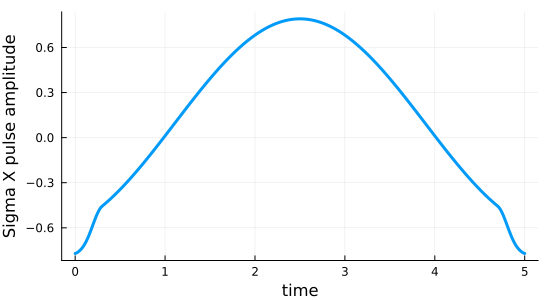

In [ ]:
plot_pulse1(opt_result_LBFGSB.optimized_controls[1], tlist)